# Alzheimer’s Disease Classification with TinyCNN in PyTorch 🧠

In this notebook, we’ll use a custom **TinyCNN** model in PyTorch to classify MRI images from the **Alzheimer's MRI Disease Classification Dataset**. This dataset includes MRI scans in four categories:

- **Non-Demented**: Healthy brain
- **Very Mild Demented**: Early signs of dementia
- **Mild Demented**: Mild cognitive decline
- **Moderate Demented**: Moderate dementia symptoms

Our goal is to build a model to distinguish between these stages, potentially aiding early diagnosis of Alzheimer’s Disease.

### Steps:
1. **Build TinyCNN**: Design a lightweight CNN for efficient image classification.
2. **Prepare the Dataset**: Load and preprocess MRI images.
3. **Train the Model**: Teach TinyCNN to identify dementia stages.
4. **Evaluate Performance**: Measure accuracy and loss.
5. **Visualize Predictions**: Check model predictions on sample images.

Let’s get started and see how well our model can support Alzheimer’s detection!


In [1]:
import torch
import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random
import pandas as pd
import seaborn as sns
import cv2
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import v2
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import time
import os
import PIL
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import DataLoader, random_split
from PIL import Image, ImageEnhance
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms


cudnn.benchmark = True

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [2]:
BASE_DIR = "/kaggle/input/alzheimer-mri-disease-classification-dataset/Alzheimer MRI Disease Classification Dataset/Data/"
disease_label_from_category = {
    0: "Mild Demented",
    1: "Moderate Demented",
    2: "Non Demented",
    3: "Very Mild Demented",
}

## Reading Data
Data is stored in the parquet file format. You can simply read this in using Pandas.

In [3]:
df = pd.read_parquet(f"{BASE_DIR}/train-00000-of-00001-c08a401c53fe5312.parquet", engine="pyarrow")
df.head()

,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2


In [4]:
test = pd.read_parquet(f"{BASE_DIR}/test-00000-of-00001-44110b9df98c5585.parquet", engine="pyarrow")

We see that these data are in a peculiar format. It is simply a dictionary which somehow is an image and then the label. The first thing we want to do is convert these cryptic "images" into a numpy array representing the intensity of the pixels (we assume the MRI are grayscale).

In [5]:
def dict_to_image(image_dict):
    if isinstance(image_dict, dict) and 'bytes' in image_dict:
        byte_string = image_dict['bytes']
        nparr = np.frombuffer(byte_string, np.uint8)
        img = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)
        return img
    else:
        raise TypeError(f"Expected dictionary with 'bytes' key, got {type(image_dict)}")

In [6]:
df['img_arr'] = df['image'].apply(dict_to_image)
df.drop("image", axis=1, inplace=True)
df.head()

,label,img_arr
0,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [7]:
test['img_arr'] = test['image'].apply(dict_to_image)
test.drop("image", axis=1, inplace=True)

Now that conversion is done we can plot a few of our images to check everything has worked correctly, we also need to understand the shape of the images so we correctly set up our model later on.

## Exploring Data

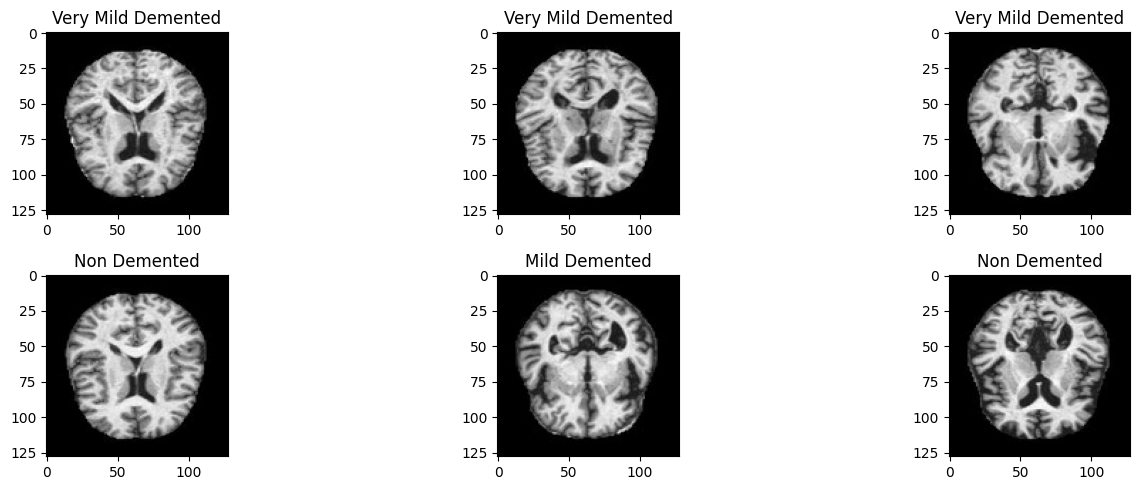

In [8]:
# Check we can actually render the image and that it looks reasonable
fig, ax = plt.subplots(2, 3, figsize=(15, 5))
axs = ax.flatten()
for axes in axs:
    rand = np.random.randint(0, len(df))
    axes.imshow(df.iloc[rand]['img_arr'], cmap="gray")
    axes.set_title(disease_label_from_category[df.iloc[rand]['label']])
plt.tight_layout()
plt.show()

So our pre-processing worked. We can clearly see this is a brain! Now let us investigate our training data a little more so we can tailor our choice of model more effectively.

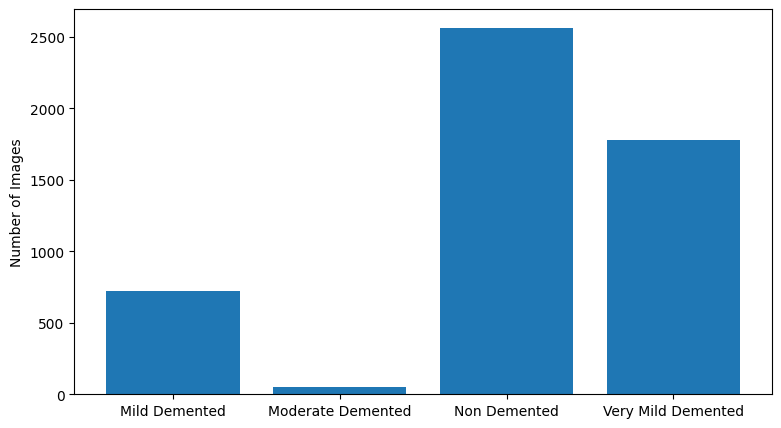

Total samples in training data = 5120


In [9]:
plt.figure(figsize=(9, 5))
plt.bar(np.arange(0, 4, 1), df['label'].value_counts().sort_index())
plt.ylabel("Number of Images")
plt.xticks(np.arange(0, 4, 1), labels=[disease_label_from_category[i] for i in range(4)])
plt.show()
print(f"Total samples in training data = {len(df)}")

What we can see from this plot is that our dataset contains almost no occurences of "moderate" severity. We anticipate our model will therefore be weakest at identifying these cases purely based on the fact it has very little to learn from.

We also observe we have ~5000 images in the dataset. This is actually a fair amount on its own but we can enhance our statistics by using augmentation! This will probably prove to be very useful for the mildly and moderately demented patient MRIs, of which we have far fewer scans.

### Step 1: Load Data and Convert Labels to Binary Classes

In this step, we’ll load MRI images from a `.parquet` file, which contains image arrays and labels. To simplify the classification, we’ll convert the dataset into a binary problem:

- **Non-Demented (Healthy)**: Label as **0**.
- **Demented**: Label as **1**, combining Very Mild, Mild, and Moderate Demented stages.

The following code loads the `.parquet` data and applies these binary labels.


In [10]:
# Define binary label mapping based on dataset description
label_mapping = {
    0: 1,  # Mild_Demented -> Demented
    1: 1,  # Moderate_Demented -> Demented
    2: 0,  # Non_Demented -> Healthy
    3: 1   # Very_Mild_Demented -> Demented
}

# Custom Dataset class for Alzheimer’s MRI binary classification with .parquet
class AlzheimerBinaryDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        # Load the .parquet file into a DataFrame
        self.dataframe = dataframe
        
         # Check unique values in the 'label' column before mapping
        print("Unique labels before mapping:", self.dataframe["label"].unique())

        # Apply binary label mapping to the 'label' column
        self.dataframe["label"] = self.dataframe["label"].map(label_mapping)

        # Verify label mapping (should only contain 0 and 1)
        unique_labels = self.dataframe["label"].unique()
        if not all(label in [0, 1] for label in unique_labels):
            raise ValueError(f"Unexpected label values found after mapping: {unique_labels}")
        
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        # Load the image array and binary label from the DataFrame
        image = self.dataframe.iloc[idx]["img_arr"]
        label = self.dataframe.iloc[idx]["label"]

        # Convert image to tensor, add channel dimension, and apply transformations if any
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # Shape (1, height, width)
        label = torch.tensor(label, dtype=torch.long)  # Ensure label is long type for classification
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [11]:
# Define any additional transforms here if needed
# Define the transformation: Resize to 28x28, normalize, and add channel dimension
transform = transforms.Compose([
    transforms.Resize((28, 28)),             # Resize to 28x28 pixels
    transforms.Normalize((0.5,), (0.5,))     # Normalize pixel values to range [-1, 1]
])

# Initialize the dataset and DataLoader
binary_dataset = AlzheimerBinaryDataset(df, transform=transform)

# Check a sample from the dataset
sample_image, sample_label = binary_dataset[0]
print("Sample image shape:", sample_image.shape)  # Should be (1, 128, 128) or similar
print("Sample label (binary):", sample_label)  # Should be 0 or 1


Unique labels before mapping: [2 0 3 1]
Sample image shape: torch.Size([1, 28, 28])
Sample label (binary): tensor(0)


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


## Step 4: Set Up Train and Validation DataLoaders

The **DataLoader** in PyTorch efficiently manages loading our Alzheimer MRI dataset in mini-batches, essential for both training and validation.

Key configurations:
- **batch_size**: Number of images per batch (e.g., 32).
- **shuffle**: Randomly shuffles training data for better generalization; not applied to validation data.
- **num_workers**: Sets the number of subprocesses for data loading.

DataLoader setup:
- **Training Set**: Used to train the model and learn patterns.
- **Validation Set**: Used to evaluate performance and model generalization after each epoch.

In [12]:
# Define the train-validation split ratio
train_ratio = 0.8  # 80% for training, 20% for validation

# Calculate the number of samples in each subset
train_size = int(train_ratio * len(binary_dataset))
val_size = len(binary_dataset) - train_size

# Split the dataset
train_dataset, val_dataset = random_split(binary_dataset, [train_size, val_size])

# Create DataLoaders for the train and validation subsets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

## Step 3: Visualize a Batch of Images

To gain insight into our Alzheimer's MRI dataset, we’ll visualize a mini-batch of images along with their binary labels (0 for **Non-Demented** and 1 for **Demented**).

The images will be displayed in a 4x8 grid, with each image labeled as **0** (Non-Demented) or **1** (Demented). This visualization allows us to check the data loading, transformations, and verify the binary labeling.


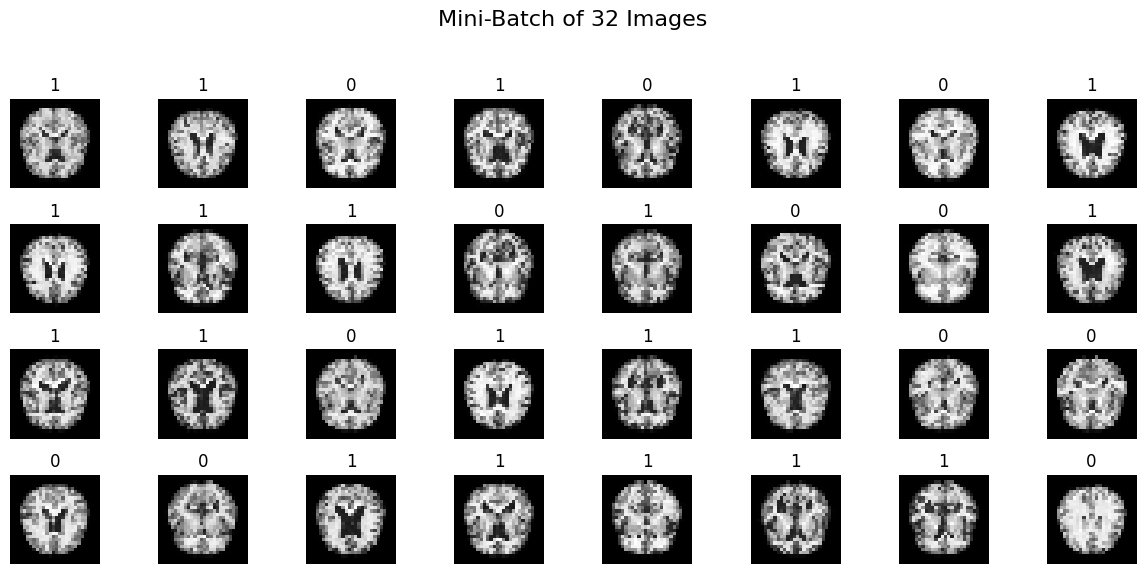

In [13]:
# Get a single batch of images and labels
batch_images, batch_labels = next(iter(train_loader))

# Display the batch of images
fig, axes = plt.subplots(4, 8, figsize=(12, 6))
fig.suptitle(f"Mini-Batch of {len(batch_images)} Images", fontsize=16)

# Loop through each image in the batch and display it
for i, (img, label) in enumerate(zip(batch_images[:32], batch_labels[:32])):  # Limit to 32 images for display
    ax = axes[i // 8, i % 8]
    img = img.squeeze().numpy()  # Convert from Tensor format to NumPy array for display
    img = img * 0.5 + 0.5  # De-normalize for visualization (if normalization was applied)
    ax.imshow(img, cmap="gray")
    ax.set_title(str(label.item()))  # Display binary label (0 or 1)
    ax.axis("off")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## Step 3: Check Data Distribution in the Alzheimer's MRI Dataset

Before training, we’ll examine the distribution of classes in the Alzheimer’s MRI dataset to ensure a balanced dataset. Understanding the data distribution helps us identify any class imbalances that might impact the model's performance.

1. **Count Images by Class**: We’ll count the number of images for each category in our binary setup:
   - **0**: Non-Demented (Healthy)
   - **1**: Demented (combining Very Mild, Mild, and Moderate Demented)

2. **Visualize the Distribution**: We’ll plot the class distribution to confirm whether the classes are represented evenly.


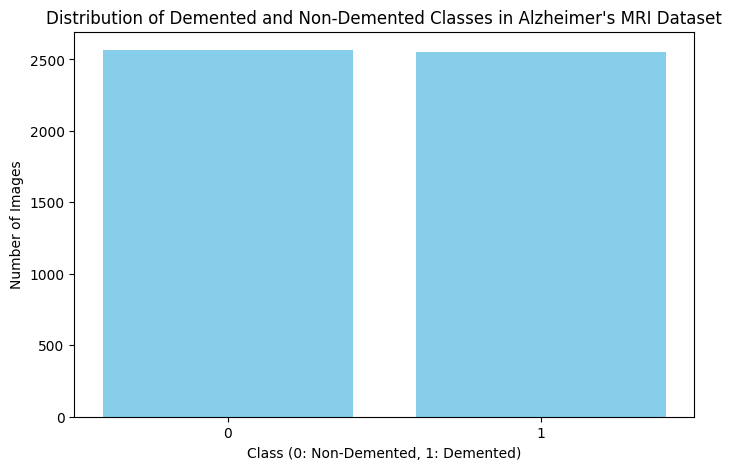

In [14]:
# Count the number of images for each class in the dataset
class_counts = Counter(binary_dataset.dataframe["label"])

# Extract class labels and counts
classes = list(class_counts.keys())
counts = list(class_counts.values())

# Plot the class distribution
plt.figure(figsize=(8, 5))
plt.bar(classes, counts, color='skyblue')
plt.xlabel("Class (0: Non-Demented, 1: Demented)")
plt.ylabel("Number of Images")
plt.title("Distribution of Demented and Non-Demented Classes in Alzheimer's MRI Dataset")
plt.xticks(classes)
plt.show()


## Step 5: Build and Initialize TinyCNN for Alzheimer's MRI Classification

For the Alzheimer's MRI binary classification task, we’ll use a custom **TinyCNN** model. This model is lightweight and efficient, designed to train quickly on small datasets, making it ideal for quick demonstrations and experiments.

1. **Define the TinyCNN Architecture**: This model includes minimal convolutional and pooling layers to capture essential image features, followed by a fully connected layer for binary classification (Non-Demented vs. Demented).
2. **Initialize the Model**: We’ll set up TinyCNN with compact layers to keep the number of trainable parameters low.
3. **Specify Output Classes**: The final layer outputs 2 classes (0 for Non-Demented, 1 for Demented).
4. **Move Model to Device**: Send the model to GPU if available, or to CPU otherwise, for faster processing.

This setup allows us to train quickly on the Alzheimer's MRI dataset while achieving meaningful results for dementia classification.


In [15]:
# Define a Depthwise Separable Convolutional Layer
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(DepthwiseSeparableConv, self).__init__()
        # Depthwise convolution
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, 
                                   stride=stride, padding=padding, groups=in_channels)
        # Pointwise convolution
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    
    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

# Define the TinyCNN model using Depthwise Separable Convolutions for Alzheimer's MRI
class TinyCNN(nn.Module):
    def __init__(self):
        super(TinyCNN, self).__init__()
        # Use Depthwise Separable Convolutions for efficient computation
        self.conv1 = DepthwiseSeparableConv(1, 16, kernel_size=3, stride=1, padding=1)  # 1 input channel, 16 output channels
        self.conv2 = DepthwiseSeparableConv(16, 32, kernel_size=3, stride=1, padding=1)  # 16 input channels, 32 output channels
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layer with 2 output classes for binary classification
        self.fc1 = nn.Linear(32 * 7 * 7, 2)  # Output layer for 2 classes (0: Non-Demented, 1: Demented)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Conv1 + ReLU + Pooling
        x = self.pool(F.relu(self.conv2(x)))  # Conv2 + ReLU + Pooling
        x = x.view(-1, 32 * 7 * 7)  # Flatten for fully connected layer
        x = self.fc1(x)  # Output layer
        return x

# Initialize the model
model = TinyCNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Model architecture:")
print(model)


Model architecture:
TinyCNN(
  (conv1): DepthwiseSeparableConv(
    (depthwise): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pointwise): Conv2d(1, 16, kernel_size=(1, 1), stride=(1, 1))
  )
  (conv2): DepthwiseSeparableConv(
    (depthwise): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16)
    (pointwise): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=2, bias=True)
)


In [16]:
# Check number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

Total parameters: 3884


## Step 6: Define Loss Function and Optimizer

To train our MobileNetV3 model, we need:
1. **Loss Function (Criterion)**: `CrossEntropyLoss` measures how well the model’s predictions match the actual labels.
2. **Optimizer**: `Adam` optimizer helps update the model’s weights based on the computed gradients.


In [17]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Step 7: Train and Evaluate TinyCNN

Now, we’ll train our **TinyCNN** model on the Alzheimer’s MRI dataset for binary classification (0: Non-Demented, 1: Demented). The training loop will iterate over multiple epochs, optimizing the model’s parameters to minimize the loss on the training set. After each epoch, we’ll evaluate the model on the validation set to monitor its performance on unseen data.

Here’s an overview of the training process:

1. **Training Phase**: For each mini-batch, we calculate the binary cross-entropy loss, perform backpropagation, and update the model parameters. We also keep track of the training accuracy.
2. **Validation Phase**: After each training epoch, we evaluate the model on the validation set to measure its generalization performance in distinguishing between Non-Demented and Demented MRI scans.
3. **Metrics**: After each epoch, we’ll print the training loss, training accuracy, validation loss, and validation accuracy to track the model's progress.

Let’s begin training!


In [18]:
# Hyperparameters
num_epochs = 10
learning_rate = 0.001

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Suitable for binary classification with class labels 0 and 1
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training and validation loop
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update metrics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Update metrics
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_loss /= total
    val_accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Print metrics after each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    print("-" * 30)


Epoch 1/10 - Training: 100%|██████████| 128/128 [00:03<00:00, 39.25it/s]


Epoch [1/10]
Train Loss: 1.5225, Train Accuracy: 0.6184
Validation Loss: 0.6977, Validation Accuracy: 0.6504
------------------------------


Epoch 2/10 - Training: 100%|██████████| 128/128 [00:03<00:00, 41.58it/s]


Epoch [2/10]
Train Loss: 0.6559, Train Accuracy: 0.6809
Validation Loss: 0.6848, Validation Accuracy: 0.6562
------------------------------


Epoch 3/10 - Training: 100%|██████████| 128/128 [00:03<00:00, 42.21it/s]


Epoch [3/10]
Train Loss: 0.5484, Train Accuracy: 0.7278
Validation Loss: 0.5401, Validation Accuracy: 0.7227
------------------------------


Epoch 4/10 - Training: 100%|██████████| 128/128 [00:02<00:00, 42.92it/s]


Epoch [4/10]
Train Loss: 0.5022, Train Accuracy: 0.7556
Validation Loss: 0.5493, Validation Accuracy: 0.7314
------------------------------


Epoch 5/10 - Training: 100%|██████████| 128/128 [00:02<00:00, 43.16it/s]


Epoch [5/10]
Train Loss: 0.4850, Train Accuracy: 0.7664
Validation Loss: 0.4966, Validation Accuracy: 0.7803
------------------------------


Epoch 6/10 - Training: 100%|██████████| 128/128 [00:03<00:00, 41.69it/s]


Epoch [6/10]
Train Loss: 0.4422, Train Accuracy: 0.7886
Validation Loss: 0.5214, Validation Accuracy: 0.7500
------------------------------


Epoch 7/10 - Training: 100%|██████████| 128/128 [00:02<00:00, 42.78it/s]


Epoch [7/10]
Train Loss: 0.4478, Train Accuracy: 0.7847
Validation Loss: 0.5078, Validation Accuracy: 0.7588
------------------------------


Epoch 8/10 - Training: 100%|██████████| 128/128 [00:03<00:00, 38.90it/s]


Epoch [8/10]
Train Loss: 0.4288, Train Accuracy: 0.8040
Validation Loss: 0.5998, Validation Accuracy: 0.7148
------------------------------


Epoch 9/10 - Training: 100%|██████████| 128/128 [00:03<00:00, 41.97it/s]


Epoch [9/10]
Train Loss: 0.4078, Train Accuracy: 0.8147
Validation Loss: 0.5535, Validation Accuracy: 0.7314
------------------------------


Epoch 10/10 - Training: 100%|██████████| 128/128 [00:03<00:00, 42.63it/s]


Epoch [10/10]
Train Loss: 0.3848, Train Accuracy: 0.8242
Validation Loss: 0.6185, Validation Accuracy: 0.7178
------------------------------


Clearly our model fit well to the training data - infact far too well! The likelihood is that we have overtrained substantially if we are 100% accurate in training.

## Step 8: Plot Training and Validation Metrics

Visualizing the loss and accuracy over epochs helps us understand how well the model is learning. Ideally, both training and validation loss should decrease, while accuracy should increase.


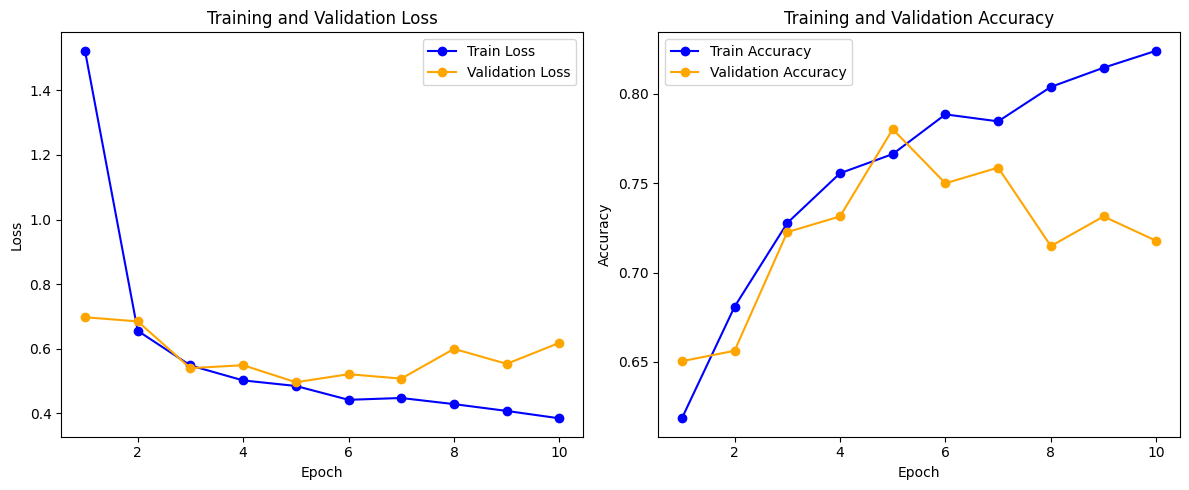

In [19]:
# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='blue', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='orange', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy', color='blue', marker='o')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='orange', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")

plt.tight_layout()
plt.show()

### Step 10: Random Test Image Prediction

To assess the model's performance on a random test image, we:

1. **Select a Random Image**: Choose a random sample from the test set.
2. **Preprocess and Predict**: Preprocess the image, pass it through the model, and convert the output to probabilities.
3. **Display Result**: Show the image with the predicted label, confidence level, and the true label for comparison.

This step gives a quick insight into how the model performs on individual test samples and its confidence in each prediction.

In [20]:
# Define any additional transforms here if needed
# Define the transformation: Resize to 28x28, normalize, and add channel dimension
transform = transforms.Compose([
    transforms.Resize((28, 28)),             # Resize to 28x28 pixels
    transforms.Normalize((0.5,), (0.5,))     # Normalize pixel values to range [-1, 1]
])

# Initialize the dataset and DataLoader
test_dataset = AlzheimerBinaryDataset(test, transform=transform)

# Check a sample from the dataset
sample_image, sample_label = test_dataset[0]
print("Sample image shape:", sample_image.shape)  # Should be (1, 128, 128) or similar
print("Sample label (binary):", sample_label)  # Should be 0 or 1

Unique labels before mapping: [3 0 2 1]
Sample image shape: torch.Size([1, 28, 28])
Sample label (binary): tensor(1)


In [21]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

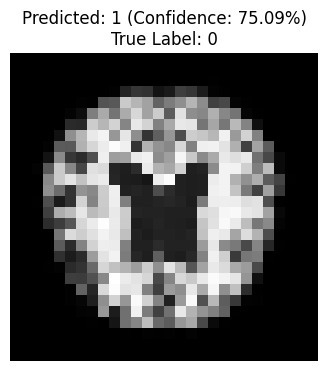

In [22]:
# Choose a random image from the test set
random_index = random.randint(0, len(test_dataset) - 1)
random_img, random_label = test_dataset[random_index]

# Prepare the image for inference
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    random_img_tensor = random_img.unsqueeze(0).to(device)  # Add batch dimension and move to device
    output = model(random_img_tensor)  # Get model output
    probabilities = torch.softmax(output, dim=1)  # Convert logits to probabilities
    predicted_label = torch.argmax(probabilities, dim=1).item()
    predicted_prob = probabilities[0, predicted_label].item()

# Display the random test image with the predicted label and probability
plt.figure(figsize=(4, 4))
plt.imshow(random_img.squeeze(), cmap="gray")
plt.title(f"Predicted: {predicted_label} (Confidence: {predicted_prob*100:.2f}%)\nTrue Label: {random_label}")
plt.axis("off")
plt.show()

## Step 11: Model Evaluation and Real-Time Performance Analysis

In this step, we’ll assess our model’s performance on the Alzheimer MRI validation set by measuring:

1. **Validation Accuracy and Loss**: Calculate the model’s accuracy and average loss on the validation set to evaluate its ability to classify MRI images for Alzheimer detection.
2. **Confusion Matrix**: Visualize the model’s performance across classification categories (e.g., Alzheimer vs. non-Alzheimer), showing correct and incorrect predictions to understand strengths and weaknesses.
3. **Inference Time**: Measure the average inference time per MRI scan to assess the model’s suitability for real-time or near-real-time clinical applications.
4. **Memory Usage**: Check memory consumption on the device to evaluate resource efficiency and ensure the model’s suitability for deployment on constrained hardware.

These metrics provide a comprehensive view of the model’s accuracy, efficiency, and resource requirements, helping us assess its performance and potential for clinical use.


In [23]:
# Initialize lists and counters for test metrics
test_loss = 0.0
correct = 0
total = 0
all_preds = []
all_labels = []

# Measure inference time
start_time = time.time()

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass and predictions
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Update test loss
        test_loss += loss.item() * images.size(0)
        
        # Get predictions and ground truth
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        
        # Store predictions and labels for confusion matrix
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate test accuracy and average loss
test_accuracy = correct / total
test_loss /= total
end_time = time.time()
inference_time = (end_time - start_time) / total

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Average Inference Time per Image: {inference_time * 1000:.2f} ms")

Test Loss: 0.6363
Test Accuracy: 0.7211
Average Inference Time per Image: 0.52 ms


In [24]:
# Generate confusion matrix and classification report
conf_matrix = confusion_matrix(all_labels, all_preds)
print("\nClassification Report:\n", classification_report(all_labels, all_preds))


Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.50      0.64       634
           1       0.66      0.94      0.77       646

    accuracy                           0.72      1280
   macro avg       0.77      0.72      0.71      1280
weighted avg       0.77      0.72      0.71      1280



### Step 11: Visualize Confusion Matrix with Enhanced Contrast

The confusion matrix below provides a detailed view of the model’s performance across Alzheimer MRI classification categories. It highlights:
- **Correct Predictions**: Found along the diagonal, where the model accurately identifies the presence or absence of Alzheimer’s disease.
- **Misclassifications**: Off-diagonal elements, indicating cases where the model incorrectly classifies MRI scans.

Using a high-contrast color map enhances readability, allowing us to easily identify patterns in the model's predictions and detect any categories that may need further refinement.


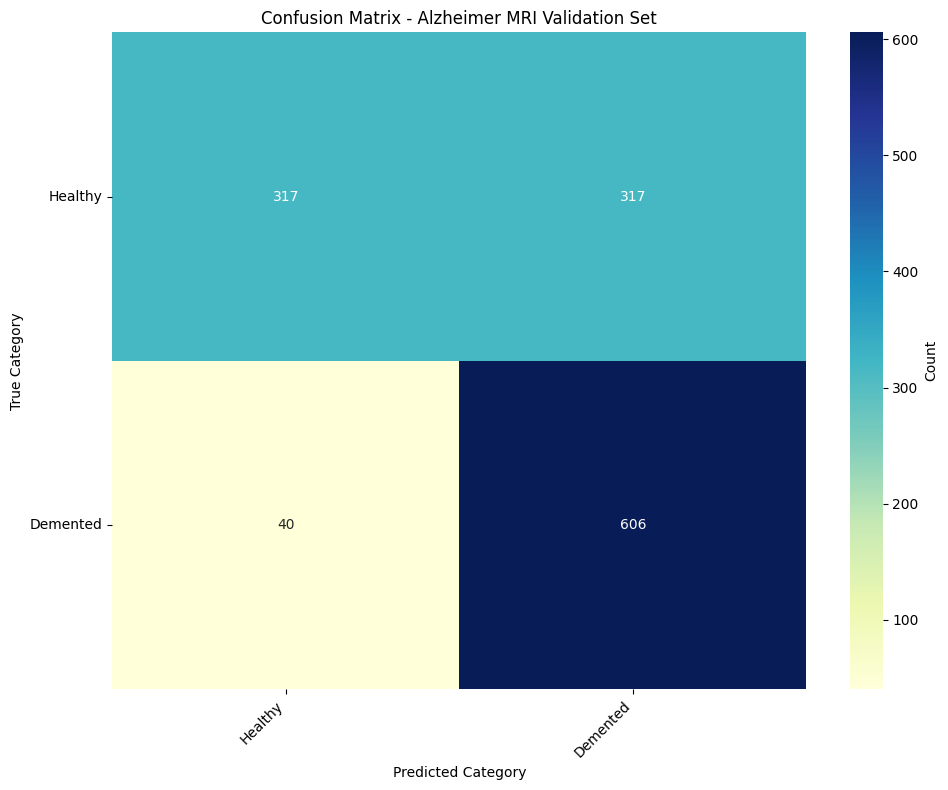

In [25]:
# Define the Alzheimer MRI class names
class_names = ["Healthy", "Demented"]

# Plot confusion matrix with improved contrast and labeled axes
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="YlGnBu", 
            xticklabels=class_names, yticklabels=class_names, 
            cbar_kws={'label': 'Count'})
plt.xlabel("Predicted Category")
plt.ylabel("True Category")
plt.title("Confusion Matrix - Alzheimer MRI Validation Set")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [26]:
if torch.cuda.is_available():
    mem_used = torch.cuda.memory_allocated(device) / 1024**2  # Convert bytes to MB
    print(f"Memory Usage: {mem_used:.2f} MB")

### Step 12: Download an Example MRI Image

To test our model on a real-world Alzheimer MRI scan, we’ll first download a sample MRI image from the web. Using `wget`, we’ll save the image in our working directory.

- **Command**: We use `wget` with the `-O` option to specify the output file name (e.g., `sample_mri.jpg`).
- **URL**: The MRI image URL is wrapped in quotes to handle any special characters.
- **`--no-check-certificate`**: This option skips SSL certificate verification, which can help avoid issues with certain URLs.

This downloaded MRI image will be used in the next step for preprocessing and model prediction.


In [29]:
!wget -O "/kaggle/working/alzheimer_mri.jpg" "https://radiologyassistant.nl/img/containers/main/dementia-role-of-mri/a5097977215b3c_caa2.jpg/b84ab65d298b2c93a0ea60e9f400758c.jpg" --no-check-certificate

--2024-11-29 01:27:29--  https://radiologyassistant.nl/img/containers/main/dementia-role-of-mri/a5097977215b3c_caa2.jpg/b84ab65d298b2c93a0ea60e9f400758c.jpg
Resolving radiologyassistant.nl (radiologyassistant.nl)... failed: Temporary failure in name resolution.
wget: unable to resolve host address 'radiologyassistant.nl'


### Step 13: Preprocess the MRI Image

To prepare the downloaded MRI image for prediction, we’ll apply the following transformations:
1. **Convert to Grayscale**: Matches the single-channel format used in training for MRI images.
2. **Resize to Match Model Input Dimensions**: Resizes the image to the dimensions expected by the model (e.g., 224x224 or 128x128, depending on your model's input size).
3. **Normalize**: Scales pixel values to the range expected by the model (e.g., mean and standard deviation values specific to MRI datasets) for accurate predictions.

These steps ensure the MRI image is in the correct format for input into the Alzheimer disease classification model.


In [28]:
# Path to the sample MRI image
image_path = "/kaggle/working/alzheimer_mri.jpg"  # Adjust path as needed

# Load the image and convert to grayscale
input_image = Image.open(image_path).convert("L")  # Step 1: Convert to grayscale (1 channel)

# Step 2: Increase contrast to highlight brain structures (optional)
enhancer = ImageEnhance.Contrast(input_image)
input_image = enhancer.enhance(1.5)  # Adjust contrast level if needed

# Display the contrast-enhanced image
plt.figure(figsize=(6, 4))
plt.imshow(input_image, cmap="gray")
plt.title("Enhanced MRI Image")
plt.axis("off")
plt.show()

# Step 3: Crop the region of interest

# Adjust coordinates (Healthy MRI)
x, y, w, h = 0, 0, 315, 408

# Adjust coordinates (Alzheimer MRI)
# x, y, w, h = 320, 0, 315, 408

# Display the original image with bounding box for the region of interest
plt.figure(figsize=(6, 4))
plt.imshow(input_image, cmap="gray")
plt.gca().add_patch(plt.Rectangle((x, y), w, h, edgecolor='red', linewidth=2, fill=False))
plt.title("MRI Image with Region of Interest")
plt.axis("off")
plt.show()

cropped_image = input_image.crop((x, y, x + w, y + h))

# Display the cropped region of interest
plt.figure(figsize=(4, 4))
plt.imshow(cropped_image, cmap="gray")
plt.title("Cropped Region of Interest")
plt.axis("off")
plt.show()

# Step 4: Resize and Normalize to match model requirements
# Define transformations: Resize to model's input size, convert to tensor, and normalize
preprocess = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize to model input dimensions
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values, adjust mean/std if needed
])

# Apply the transformations to prepare for model input
input_tensor = preprocess(cropped_image).unsqueeze(0)  # Add batch dimension (1, 1, 224, 224)

# Display the final preprocessed image
plt.figure(figsize=(4, 4))
plt.imshow(input_tensor.squeeze().cpu().numpy(), cmap="gray")
plt.title("Preprocessed MRI Image (224x224) for Alzheimer Model")
plt.axis("off")
plt.show()

# Print tensor shape to verify it's ready for model input
print("Input tensor shape for Alzheimer model:", input_tensor.shape)


UnidentifiedImageError: cannot identify image file '/kaggle/working/alzheimer_mri.jpg'

### Step 15: Display Top Class Probabilities

After making a prediction, we’ll display the model's top 2 class probabilities (Healthy and Demented) to gain insight into its confidence and identify the closest alternative prediction.

- **Softmax Transformation**: Converts the model output to probabilities, allowing us to interpret the confidence of each prediction.
- **Top 2 Predictions**: Displays the probabilities for the "Healthy" and "Demented" classes, helping us understand the model's certainty in its diagnosis.
- **Visualization**: The predicted class is displayed on the MRI image, with the probabilities for both classes listed below.

This step allows us to assess the model’s confidence level in its classification, providing insights into potential ambiguities between "Healthy" and "Demented" classifications.


In [30]:
# Define the Alzheimer MRI class names
class_names = ["Healthy", "Demented"]

# Check if CUDA (GPU) is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the specified device
model.to(device)

# Move tensor to the same device
input_tensor = input_tensor.to(device)

# Set the model to evaluation mode
model.eval()
with torch.no_grad():
    output = model(input_tensor)  # Forward pass
    probabilities = F.softmax(output, dim=1)  # Convert logits to probabilities
    top_probs, top_indices = torch.topk(probabilities, 2)  # Get top 2 probabilities and indices

# Convert probabilities to percentage format
top_probs = top_probs.squeeze().cpu().numpy() * 100
top_indices = top_indices.squeeze().cpu().numpy()

# Display the original MRI image and predictions
plt.imshow(cropped_image, cmap="gray")
plt.title(f"Predicted Label: {class_names[top_indices[0]]} ({top_probs[0]:.2f}%)")
plt.axis("off")
plt.show()

# Print the top 2 class probabilities
print("Top 2 Predictions:")
for i in range(2):
    print(f"{class_names[top_indices[i]]}: {top_probs[i]:.2f}%")


NameError: name 'input_tensor' is not defined